## Image segmantation <img align="right" src="image/gistda.png" width="200" height="200">

This notebook demonstrates  methods for conducting [image segmentation](https://scikit-image.org/docs/stable/user_guide/tutorial_segmentation.html), which is a common image analysis technique used to transform a digital satellite image into objects. 
In brief, image segmentation aims to partition an image into segments, where each segment consists of a group of pixels with similar characteristics. 
A number of algorithms exist to perform image segmentation, one of which are shown here:

1. [Quickshift](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift), implemented through the python package `scikit-image`

### Load Packages

In [1]:
%matplotlib inline

import datacube
import xarray as xr
import numpy as np
import scipy
import matplotlib.pyplot as plt
from osgeo import gdal
from datacube.utils.cog import write_cog
from skimage.segmentation import quickshift
from dream_river.plotimg import rgb
from dream_river.indices import cal_index

### Connect to datacube

In [2]:
#connect to datacube
dc = datacube.Datacube(app='Image_segmentation')

### Set Query Parameter for load data

In [3]:
# Create a query object
query = {"product": "ls8_collections_sr_scene",
         "measurements": ['red','green', 'blue',"nir"],
         "y": (15.113, 15.052),
         "x": (102.514, 102.590),
         "time": ("2018-06-29","2018-06-30"),
         "resolution": (-30,30),
         "output_crs": "EPSG:32647"
        }

### Load data from datacube

In [4]:
# Loading data using dc.load()
ds = dc.load(**query)
ds

<xarray.Dataset>
Dimensions:      (time: 2, y: 231, x: 277)
Coordinates:
  * time         (time) datetime64[ns] 2018-06-30T03:30:14 2018-06-30T03:30:38
  * y            (y) float64 1.674e+06 1.674e+06 ... 1.667e+06 1.667e+06
  * x            (x) float64 8.778e+05 8.778e+05 ... 8.86e+05 8.861e+05
    spatial_ref  int32 32647
Data variables:
    red          (time, y, x) int16 345 280 154 126 222 ... 1422 805 283 380 495
    green        (time, y, x) int16 287 246 172 146 203 ... 1120 765 437 527 623
    blue         (time, y, x) int16 146 119 68 46 97 79 ... 657 338 172 216 253
    nir          (time, y, x) int16 540 563 658 612 732 ... 3415 3679 3788 3766
Attributes:
    crs:           EPSG:32647
    grid_mapping:  spatial_ref

### Display study area

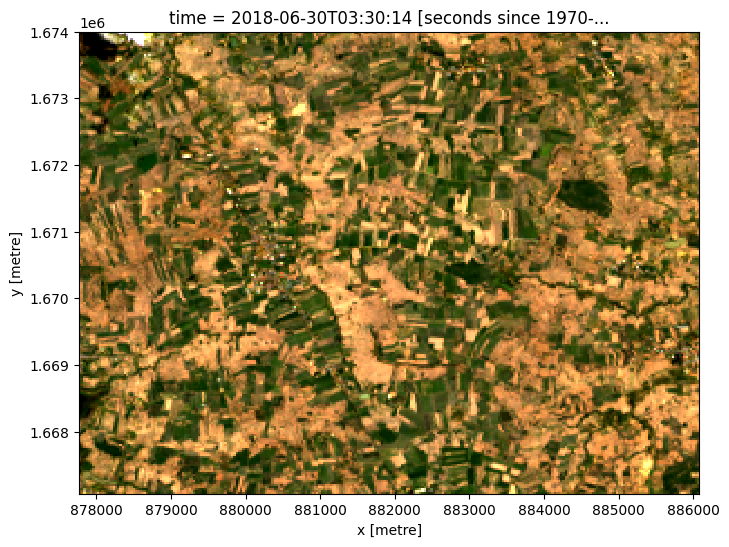

In [5]:
# Plot as an RGB image select first timestep 
rgb(ds, bands=['red','green', 'blue'], index=[0])

### Calculate NDVI index

In [6]:
# calculate ndvi
# First we calculate NDVI on each image in the timeseries
ds_index = cal_index(ds, index='NDVI', collection='ls8_collections_sr_scene')


In [7]:
ds_index

<xarray.Dataset>
Dimensions:      (time: 2, y: 231, x: 277)
Coordinates:
  * time         (time) datetime64[ns] 2018-06-30T03:30:14 2018-06-30T03:30:38
  * y            (y) float64 1.674e+06 1.674e+06 ... 1.667e+06 1.667e+06
  * x            (x) float64 8.778e+05 8.778e+05 ... 8.86e+05 8.861e+05
    spatial_ref  int32 32647
Data variables:
    red          (time, y, x) int16 345 280 154 126 222 ... 1422 805 283 380 495
    green        (time, y, x) int16 287 246 172 146 203 ... 1120 765 437 527 623
    blue         (time, y, x) int16 146 119 68 46 97 79 ... 657 338 172 216 253
    nir          (time, y, x) int16 540 563 658 612 732 ... 3415 3679 3788 3766
    NDVI         (time, y, x) float64 0.2203 0.3357 0.6207 ... 0.8177 0.7677
Attributes:
    crs:           EPSG:32647
    grid_mapping:  spatial_ref

In [8]:
# select first time_step of image
ds_plot = ds_index.NDVI.isel(time=0)

### Plot NDVI image

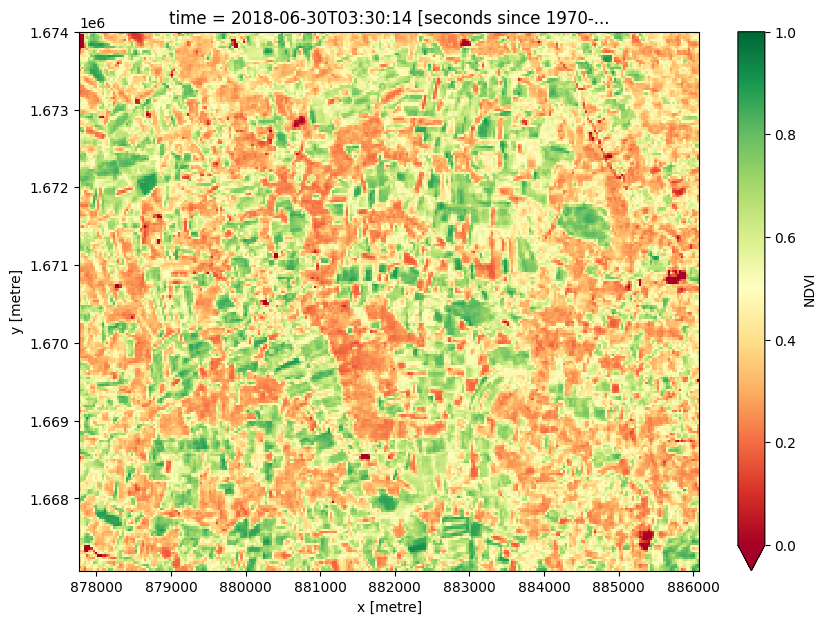

In [9]:
ds_plot.plot(vmin=0, vmax=1, cmap = 'RdYlGn', figsize=(10, 7))

### Quickshift Segmentation

Using the function [quickshift](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift) from the python package `scikit-image`, we will conduct an image segmentation on the mean NDVI array.  We then calculate a zonal mean across each segment using the input dataset. Our last step is to export our results as a GeoTIFF.

Follow the quickshift hyperlink above to see the input parameters to the algorithm, and the following [link](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html) for an explanation of quickshift and other segmentation algorithms in `scikit-image`.

In [10]:
# Convert our mean NDVI xarray into a numpy array, we need
# to be explicit about the datatype to satisfy quickshift
input_array = ds_plot.values.astype(np.float64)

Code below, you can set your own parameters for image segmentation [Read here !!! how to set parameters](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift)

In [11]:
# Calculate the segments
segments = quickshift(input_array,
                      kernel_size=2,
                      convert2lab=False,
                      max_dist=2,
                      ratio=1.0)

In [12]:
# Calculate the zonal mean NDVI across the segments
segments_zonal_mean_qs = scipy.ndimage.mean(input=input_array,
                                            labels=segments,
                                            index=segments)

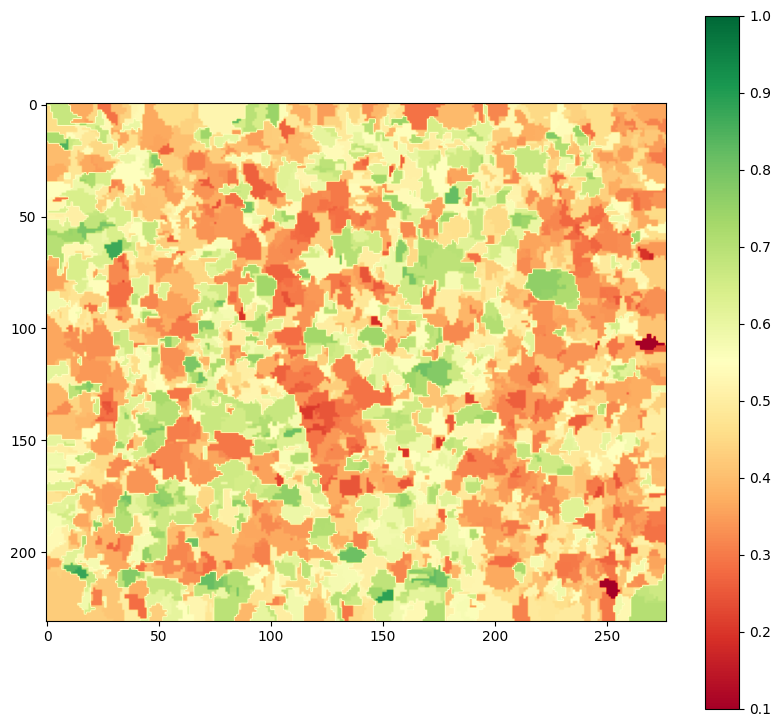

In [13]:
# Plot to see result
plt.figure(figsize=(10, 10))
plt.imshow(segments_zonal_mean_qs, cmap='RdYlGn', vmin=0.1, vmax=1.0)
plt.colorbar(shrink=0.9)

### Export result to GeoTIFF
To export our result to a GeoTIFF raster file, we first need to convert our plain `np.array` back to an `xr.DataArray`, then use the `write_cog` function.

In [ ]:
# Convert numpy array to xarray.DataArray
segments_zonal_mean_qs = xr.DataArray(segments_zonal_mean_qs, 
             coords=ndvi.coords, 
             dims=['y', 'x'], 
             attrs=ndvi.attrs)

# Write array to GeoTIFF
write_cog(geo_im=segments_zonal_mean_qs,
          fname='masked_data.tif',
          overwrite=True);